In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit, vmap, grad
import jax.random as random
rng = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree

import matplotlib.pyplot as plt
import pandas as pd

from utils import train_jp, eval_Cauchy, eval_Cauchy_vmap, merge_weights_aniso
from utils_node import NODE, init_layers
from fem import plotmesh, fe_solver_2D, neoHookean_const_model, vahid_anisohyper_inv

import GPy
from jaxinterp2d import interp2d

from scipy.optimize import fsolve

In [2]:
def nn_fpass(H, params):
    Ws, bs = params
    N_layers = len(Ws)
    for i in range(N_layers - 1):
        H = jnp.matmul(H, Ws[i]) + bs[i]
        H = jnp.tanh(H)
    H = jnp.matmul(H, Ws[-1]) + bs[-1]
    return H

def init_params_nn(layers, key):
  Ws = []
  bs = []
  for i in range(len(layers) - 1):
    std_glorot = jnp.sqrt(2/(layers[i] + layers[i + 1]))
    key, subkey = random.split(key)
    Ws.append(random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    bs.append(jnp.zeros(layers[i + 1]))
  return [Ws, bs]

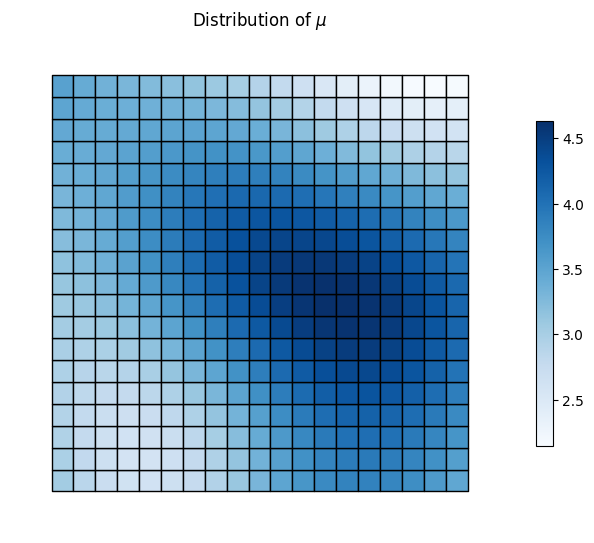

In [2]:
# Generate a synthetic heterogeneous field and assume some boundary conditions
nvar = 2
nrow = 20
ncol = 20
n_node = nrow*ncol
n_elem = n_node-nrow-ncol+1
pts_x = np.linspace(0,1,nrow)
pts_y = np.linspace(0,1,ncol)
node_X, node_Y = np.meshgrid(pts_x,pts_y)
node_X = np.vstack((node_Y.flatten(), node_X.flatten())).T

# Identify the boundary nodes
rgt_bd = np.where(node_X[:,0]>0.99)
top_bd = np.where(node_X[:,1]>0.99)
lft_bd = np.where(node_X[:,0]<0.01)
bot_bd = np.where(node_X[:,1]<0.01)
rgt_bd_x = node_X[rgt_bd,0].flatten()
rgt_bd_y = node_X[rgt_bd,1].flatten()
top_bd_x = node_X[top_bd,0].flatten()
top_bd_y = node_X[top_bd,1].flatten()
lft_bd_x = node_X[lft_bd,0].flatten()
lft_bd_y = node_X[lft_bd,1].flatten()
bot_bd_x = node_X[bot_bd,0].flatten()
bot_bd_y = node_X[bot_bd,1].flatten()

elements = np.zeros((n_elem, 4), dtype=np.int_)

i=0
j=0
while i < n_node - ncol: #exclude 1 row at the top because there are no nodes above those to form elements.
    if (i+1)%ncol != 0: #Skip the nodes on the right
        elements[j,0] = i
        elements[j,3] = i+1
        elements[j,2] = i+ncol + 1
        elements[j,1] = i+ncol
        j+= 1
    i+= 1

k = GPy.kern.RBF(input_dim=2,lengthscale=0.4)
mean = np.zeros((node_X.shape[0]))
C = k.K(node_X,node_X)

mu = np.random.multivariate_normal(mean,C,1).flatten() + 3.0

fig, ax = plt.subplots(figsize=(7,7))
c_elem = 0.25*(mu[elements[:,0]] + mu[elements[:,1]] + mu[elements[:,2]] + mu[elements[:,3]])
plotmesh(elements, node_X, c_elem, title='Distribution of $\mu$', ax=ax); 

Fx = np.random.uniform()+0.5

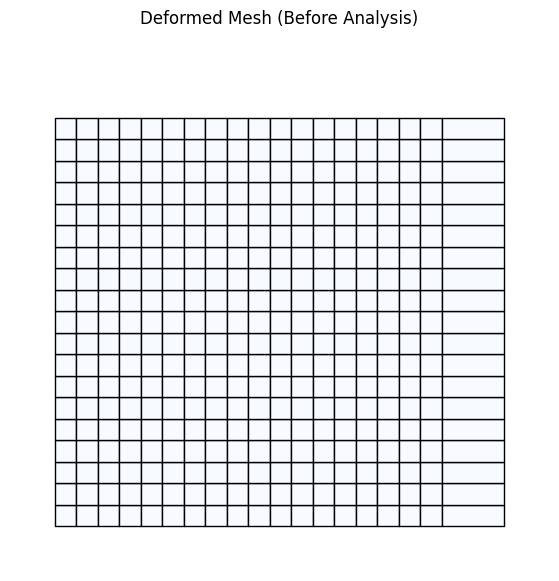

In [3]:
node_x = np.zeros_like(node_X)
DOF_fmap = np.zeros((n_node,2),dtype=int)
dof = 0
for i in range(n_node):
    X = node_X[i]
    node_x[i] = node_X[i]
    if X[0]<0.001:
        DOF_fmap[i,0] = -1
        node_x[i,0] = 0
        if X[1] < 0.001:
            DOF_fmap[i,1] = -1
            node_x[i,1] = 0
        else:
            DOF_fmap[i,1] = dof
            dof+= 1
    elif X[0]>0.999:
        DOF_fmap[i,0] = -1
        node_x[i,0] = 1.1
        DOF_fmap[i,1] = dof
        dof+= 1
    else:
        DOF_fmap[i,0] = dof
        DOF_fmap[i,1] = dof+1
        dof+=2 
plotmesh(elements, node_x, c=np.ones([node_X.shape[0]]), title='Deformed Mesh (Before Analysis)', cbar = False); 

In [4]:
class hetero_neoHookean(): # Neo Hookean by default.
    def __init__(self, c1 = 1.0):
        self.c1 = c1

    def sigma(self, F, node_X=None, node_x=None):
        c1 = interp2d(node_X[0], node_X[1], pts_x, pts_y, mu.reshape([nrow,ncol]))
        # c1 = self.c1
        J = np.linalg.det(F)
        b = F @ F.T
        p = 2*c1/J**2
        return -p*np.eye(2) + 2*c1*b
    
    def D(self, F, node_X=None, node_x=None):
        c1 = interp2d(node_X[0], node_X[1], pts_x, pts_y, mu.reshape([nrow,ncol]))
        # c1 = self.c1
        J = np.linalg.det(F)
        p = 2*c1/J**2
        return np.array([[4*p, 2*p,   0],
                         [2*p, 4*p,   0],
                         [0,     0, 2*p]])

In [5]:
# As a test, first solve using homogeneous neo Hookean
# const_model = neoHookean_const_model(c1 = 1.0)
const_model = hetero_neoHookean(c1=1.0)
mysolver = fe_solver_2D(node_X, node_x, elements, DOF_fmap, const_model)
mysolver.n_print = 1
mysolver.itermax = 20
node_x, F, sigma = mysolver.solve()

Solving...
iter 1,   residual = 13.460670431458006
iter 2,   residual = 29.25695454302445
iter 3,   residual = 16.87950529484851
iter 4,   residual = 9.533744397518188
iter 5,   residual = 5.21314391389696
iter 6,   residual = 2.6879900829012473
iter 7,   residual = 1.3303383405705909
iter 8,   residual = 0.6173602222056347
iter 9,   residual = 0.20060184543684603
iter 10,   residual = 0.0480090969088498
iter 11,   residual = 0.016373958985212708
iter 12,   residual = 0.006539990705887908
iter 13,   residual = 0.0027487679690467617
iter 14,   residual = 0.0011851470581472952
iter 15,   residual = 0.0005204383408680594
iter 16,   residual = 0.00023179507806530498
iter 17,   residual = 0.00010443410779116751
iter 18,   residual = 4.751108280245978e-05
iter 19,   residual = 2.17959347666213e-05
iter 20,   residual = 1.0072183738810514e-05
Reached maximum number of iterations without converging. Either increase itermax or decrease tolerance.


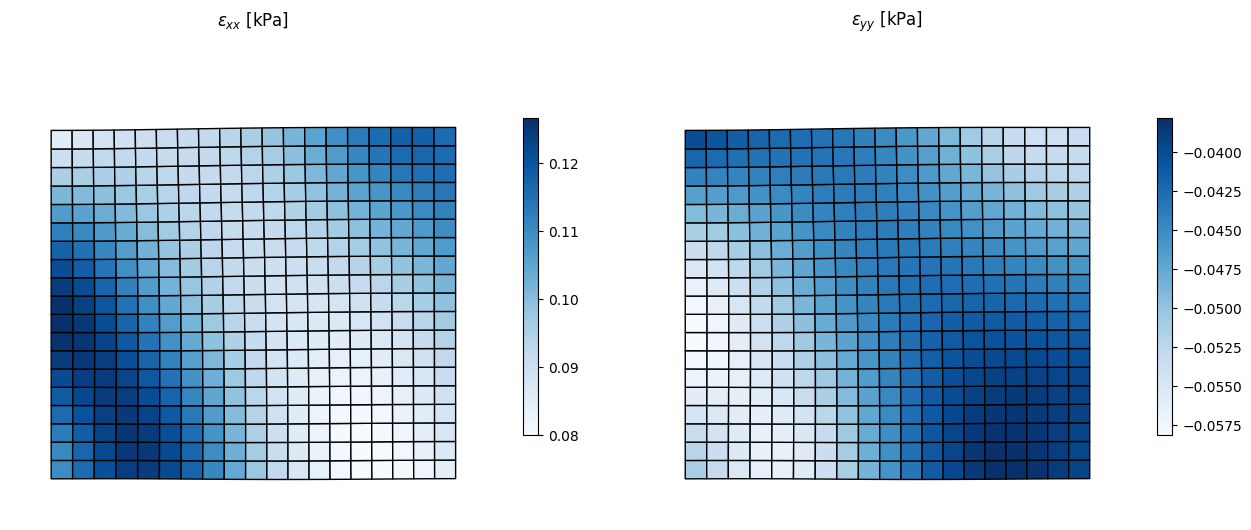

In [6]:
epsx = F[:,0,0]-1.0
epsy = F[:,1,1]-1.0
strains = np.array([epsx, epsy])

fig, axes = plt.subplots(1,2,figsize=(15,7))
plotmesh(elements, node_x, epsx, title='$\epsilon_{xx}$ [kPa]', ax=axes[0]); 
plotmesh(elements, node_x, epsy, title='$\epsilon_{yy}$ [kPa]', ax=axes[1]); 

In [7]:
# identify the boundaries
rgt_bd_elems = []
top_bd_elems = []
lft_bd_elems = []
bot_bd_elems = []
for i, e in enumerate(elements):
    if any([node_X[e[i],0]>0.99 for i in range(4)]):
        rgt_bd_elems.append(i)
    if any([node_X[e[i],1]>0.99 for i in range(4)]):
        top_bd_elems.append(i)
    if any([node_X[e[i],0]<0.01 for i in range(4)]):
        lft_bd_elems.append(i)
    if any([node_X[e[i],1]<0.01 for i in range(4)]):
        bot_bd_elems.append(i)

# get the reaction forces by integrating the stresses of the boundary elements
rgt_bd_frc = np.sum(sigma[rgt_bd_elems,0,0])
lft_bd_frc = np.sum(sigma[lft_bd_elems,0,0])
top_bd_frc = np.sum(sigma[top_bd_elems,1,1])
bot_bd_frc = np.sum(sigma[bot_bd_elems,1,1])
Fx = 0.5*(rgt_bd_frc + lft_bd_frc)
Fy = 0.5*(top_bd_frc + bot_bd_frc)

# get the center points of the elements
elem_X = np.array([0.25*(node_X[e[0]] + node_X[e[1]] + node_X[e[2]] + node_X[e[3]]) for e in elements])
rgt_bd_X = elem_X[rgt_bd_elems]
top_bd_X = elem_X[top_bd_elems]
lft_bd_X = elem_X[lft_bd_elems]
bot_bd_X = elem_X[bot_bd_elems]

with open('params/2d_strainfield.npy', 'wb') as f:
    pickle.dump([node_X, node_x, elements, n_node, n_elem, Fx, Fy, strains, elem_X, rgt_bd_X, top_bd_X, lft_bd_X, bot_bd_X], f)

In [3]:
with open('params/2d_strainfield.npy', 'rb') as f:
    node_X, node_x, elements, n_node, n_elem, Fx, Fy, strains, elem_X, rgt_bd_X, top_bd_X, lft_bd_X, bot_bd_X = pickle.load(f)

In [6]:
# Fit a NODE to the homogenized behavior

class NODE_model_iso(): #isotropic
    def __init__(self, params_I1):
        self.params_I1, self.I1_bias = params_I1
    def Psi1(self, I1, I2):
        I1 = I1-3.0
        return NODE(I1, self.params_I1) + jnp.exp(self.I1_bias)
    def Psi2(self, I1, I2):
        return 0.0
def init_params_iso(common_layers, sample_layers, key):
    params_I1_common = init_layers(common_layers, key)
    params_I1_sample = init_layers(sample_layers, key)
    params_I1 = (params_I1_common, params_I1_sample)
    I1_bias = -3.0
    return params_I1, I1_bias

# Homogenize the strains
epsx_mean = np.mean(strains[0])
epsy_mean = np.mean(strains[1])
sgmx_mean = Fx/len(rgt_bd_elems)
sgmy_mean = Fy/len(top_bd_elems)
lamb_sigma_m = np.array([epsx_mean+1.0, epsy_mean+1.0, sgmx_mean, sgmy_mean]).reshape([1,-1])

n_neurons = 4
# Define the loss function for when training all params
@jit
def loss_sig_all(params, lamb_sigma, key):
    model   = NODE_model_iso(params)
    lambx   = lamb_sigma[:,0]
    lamby   = lamb_sigma[:,1]
    sgmx_gt  = lamb_sigma[:,2]
    sgmy_gt  = lamb_sigma[:,3]
    sgm = eval_Cauchy_vmap(lambx,lamby, model)
    sgmx_pr, sgmy_pr = sgm[:,0,0], sgm[:,1,1]
    return np.mean((sgmx_pr-sgmx_gt)**2+(sgmy_pr-sgmy_gt)**2)

# Initialize NODEs and the optimizer
key = random.PRNGKey(0)
common_layers = [1, n_neurons, n_neurons]
sample_layers = [n_neurons,1]
node_params = init_params_iso(common_layers, sample_layers, key)
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(node_params)

# Train
node_params, train_loss, _ = train_jp(loss_sig_all, lamb_sigma_m, get_params, opt_update, opt_state, key, nIter = 10000, print_freq=1000)

it 1000, train loss = 5.665652e-09
it 2000, train loss = 5.665652e-09
it 3000, train loss = 5.665652e-09
it 4000, train loss = 5.665652e-09
it 5000, train loss = 5.665652e-09
it 6000, train loss = 5.665652e-09
it 7000, train loss = 5.665652e-09
it 8000, train loss = 5.665652e-09
it 9000, train loss = 5.665652e-09
it 10000, train loss = 5.665652e-09


In [7]:
mymodel = NODE_model_iso(node_params)
sgm = eval_Cauchy(epsx_mean+1.0,epsy_mean+1.0, mymodel)
sgmx, sgmy = sgm[0,0], sgm[1,1]
print('gt sgmx & sgmy: ', sgmx_mean, sgmy_mean)
print('pr sgmx & sgmy: ', sgmx, sgmy)

gt sgmx & sgmy:  2.131173167117113 8.20790913174575e-05
pr sgmx & sgmy:  2.1311731673575833 6.808562709539294e-06


In [8]:
# Fit a function Λ that maps x,y ∈ [0,1] to the individual-specific parameters of this NODE with a maximum variance of, say, 1%
phi, unravel = ravel_pytree(node_params)
n_phi = len(phi)

def loss_Lambda(params, inp, key):
    out_pr = nn_fpass(inp, params)
    return jnp.mean((out_pr-phi)**2)

Lambda_layers = [2,5,10,n_phi]
Lambda_params = init_params_nn(Lambda_layers, key)
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(Lambda_params)

inp = np.array(np.meshgrid(np.linspace(0,1,20), np.linspace(0,1,20))).reshape([2,-1]).T
Lambda_params, train_loss, _ = train_jp(loss_Lambda, inp, get_params, opt_update, opt_state, key, nIter = 2000, print_freq=1000)

it 1000, train loss = 6.410297e-03
it 2000, train loss = 1.711168e-03


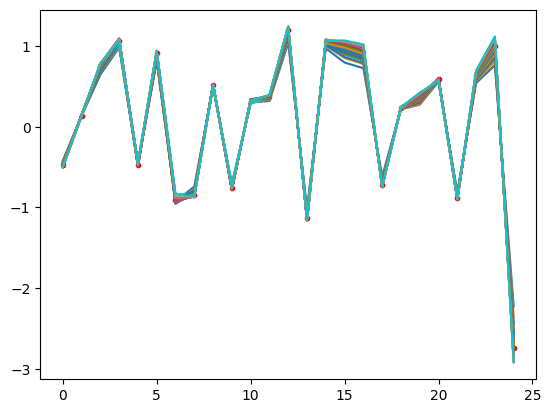

In [9]:
fig, ax = plt.subplots()
ax.plot(phi, 'r.-')
for y in np.linspace(0,1,4):
    for x in np.linspace(0,1,10):
        params = nn_fpass(np.array([x,y]).reshape([1,-1]), Lambda_params)
        ax.plot(params[0])

In [ ]:
# Train with the heterogeneity
def get_stresses(x, y, Lambda_params):
    # get the strains for this x and y using 2D interpolation
    n = int(np.sqrt(len(elements)))
    pts_x = elem_X[[i*n for i in range(n)],0] # for x we need to take points 1, n, 2n, ..., nn
    pts_y = elem_X[:n,1] # for y we need to take points 1, 2, 3, ... n
    strains_x = strains[0].reshape([n,n])
    strains_y = strains[1].reshape([n,n])
    epsx = interp2d(x, y, pts_x, pts_y, strains_x)
    epsy = interp2d(x, y, pts_x, pts_y, strains_y)

    # get NODE individual-specific params, phi, from the Lambda NN
    Lambda_inp = jnp.array([x,y]).reshape([-1,2])
    phi = nn_fpass(Lambda_inp, Lambda_params).flatten()
    # Make predictions with this NODE
    mymodel = NODE_model_iso(unravel(phi))
    sgm = eval_Cauchy(epsx+1.0,epsy+1.0, mymodel)
    return sgm[0,0], sgm[1,0], sgm[0,1], sgm[1,1]
get_stresses_vmap = vmap(get_stresses, in_axes=(0,0,None), out_axes=(0,0,0,0))

get_sgm_xx = lambda x, y, Lambda_params: get_stresses(x, y, Lambda_params)[0]
get_sgm_yx = lambda x, y, Lambda_params: get_stresses(x, y, Lambda_params)[1]
get_sgm_xy = lambda x, y, Lambda_params: get_stresses(x, y, Lambda_params)[2]
get_sgm_yy = lambda x, y, Lambda_params: get_stresses(x, y, Lambda_params)[3]

grad_sgm_xx_x = vmap(grad(get_sgm_xx, argnums=0), in_axes=(0,0,None), out_axes=0) # should return dsgm_xx/dx
grad_sgm_yx_x = vmap(grad(get_sgm_yx, argnums=0), in_axes=(0,0,None), out_axes=0)
grad_sgm_xy_y = vmap(grad(get_sgm_yx, argnums=1), in_axes=(0,0,None), out_axes=0)
grad_sgm_yy_y = vmap(grad(get_sgm_yy, argnums=1), in_axes=(0,0,None), out_axes=0)

def bd_forces(Lambda_params, input, key):
    rgt_bd_sgm = get_stresses_vmap(rgt_bd_X[:,0], rgt_bd_X[:,1], Lambda_params)
    top_bd_sgm = get_stresses_vmap(top_bd_X[:,0], top_bd_X[:,1], Lambda_params)
    lft_bd_sgm = get_stresses_vmap(lft_bd_X[:,0], lft_bd_X[:,1], Lambda_params)
    bot_bd_sgm = get_stresses_vmap(bot_bd_X[:,0], bot_bd_X[:,1], Lambda_params)

    rgt_bd_frc = jnp.sum(rgt_bd_sgm[0]) # Assume area of edge = 1.0
    top_bd_frc = jnp.sum(top_bd_sgm[3])
    lft_bd_frc = jnp.sum(lft_bd_sgm[0])
    bot_bd_frc = jnp.sum(bot_bd_sgm[3])
    return rgt_bd_frc, top_bd_frc, lft_bd_frc, bot_bd_frc
def divergence(Lambda_params, input, key):
    X_colloc = random.uniform(key, (50,2))
    dsgm_xx_dx = grad_sgm_xx_x(X_colloc[:,0], X_colloc[:,1], Lambda_params)
    dsgm_xy_dy = grad_sgm_xy_y(X_colloc[:,0], X_colloc[:,1], Lambda_params)
    dsgm_yx_dx = grad_sgm_yx_x(X_colloc[:,0], X_colloc[:,1], Lambda_params)
    dsgm_yy_dy = grad_sgm_yy_y(X_colloc[:,0], X_colloc[:,1], Lambda_params)
    
    div_x = jnp.sum(dsgm_xx_dx + dsgm_xy_dy) # = dsgm_xx/dx + dsgm_xy/dy
    div_y = jnp.sum(dsgm_yx_dx + dsgm_yy_dy) # = dsgm_yx/dx + dsgm_yy/dy
    return div_x, div_y
def loss(Lambda_params, input, key):
    div_x, div_y = divergence(Lambda_params, input, key)
    rgt_bd_frc, top_bd_frc, lft_bd_frc, bot_bd_frc = bd_forces(Lambda_params, input, key)
    return div_x**2 + div_y**2 + 10*((rgt_bd_frc-Fx)**2 + (top_bd_frc-Fy)**2 + (lft_bd_frc-Fx)**2 + (bot_bd_frc-Fy)**2)

opt_init, opt_update, get_params = optimizers.adam(5.e-4)
opt_state = opt_init(Lambda_params)
Lambda_params, train_loss, metrics = train_jp(loss, None, get_params, opt_update, opt_state, key, nIter = 1000000, print_freq=1000, metric_fns=[bd_forces, divergence])
with open('params/synthetic.npy', 'wb') as f:
    pickle.dump([node_X, strains, Fx, Fy, node_params, Lambda_params, train_loss, metrics], f)

 /var/folders/1f/rngrmz8x3lsd60h6dd90ncwm0000gr/T/ipykernel_59005/1748662417.py:1: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


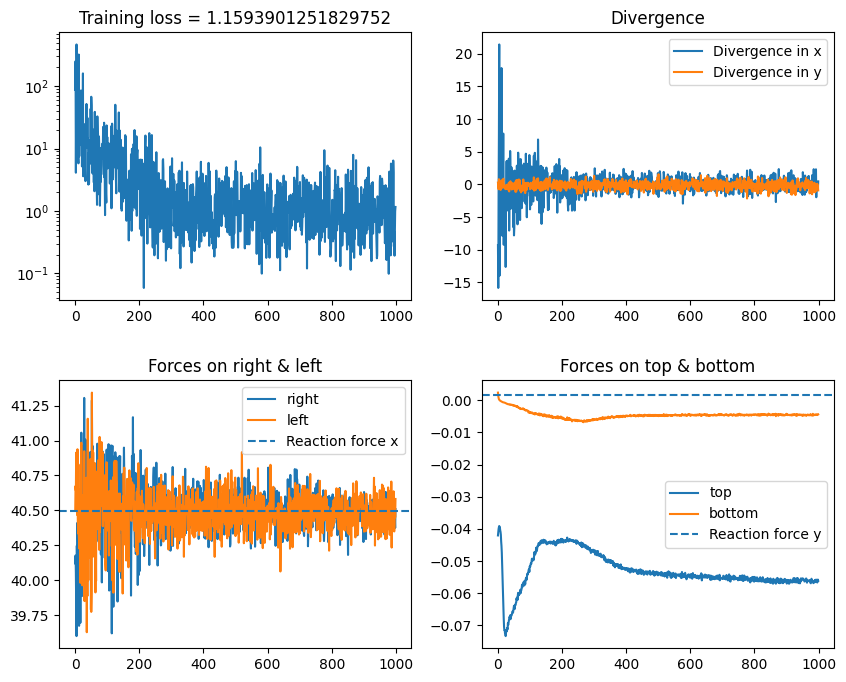

In [14]:
forces, div = np.array(metrics).T
forces = np.array([*forces])
div = np.array([*div])

fig, ax = plt.subplots(2,2,figsize=(10,8))
plt.subplots_adjust(hspace=0.3)
ax[0,0].plot(train_loss)
ax[0,1].plot(div[:,0], label='Divergence in x')
ax[0,1].plot(div[:,1], label='Divergence in y')

ax[1,0].plot(forces[:,0], label='right')
ax[1,1].plot(forces[:,1], label='top')
ax[1,0].plot(forces[:,2], label='left')
ax[1,1].plot(forces[:,3], label='bottom')

ax[1,0].axhline(Fx, linestyle='--', label='Reaction force x')
ax[1,1].axhline(Fy, linestyle='--', label='Reaction force y')

# ax[0,0].set(yscale='log')
ax[0,0].set(title='Training loss = ' + str(train_loss[-1]), yscale = 'log')
ax[0,1].set(title='Divergence')
ax[1,0].set(title='Forces on right & left')
ax[1,1].set(title='Forces on top & bottom')
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

In [4]:
with open('params/synthetic.npy', 'rb') as f:
    node_X, strains, Fx, Fy, node_params, Lambda_params, train_loss, metrics = pickle.load(f)
_, unravel = ravel_pytree(node_params)

In [6]:
class NODE_SEDF_iso():
    def __init__(self, Lambda_params=None, unravel=None):
        self.Lambda_params = Lambda_params
        self.unravel = unravel
        return
    def nn_fpass(self, H, params):
        Ws, bs = params
        N_layers = len(Ws)
        for i in range(N_layers - 1):
            H = jnp.matmul(H, Ws[i]) + bs[i]
            H = jnp.tanh(H)
        H = jnp.matmul(H, Ws[-1]) + bs[-1]
        return H
    def fiberangle(self, node_X):
        return 0.0
    
    def Psi_i(self, I1, I2, Iv, Iw, X):
        Lambda_inp = np.array([X[0],X[1]]).reshape([-1,2])
        phi = self.nn_fpass(Lambda_inp, self.Lambda_params).flatten()
        params = self.unravel(phi)
        params_I1, I1_bias = params

        I1 = I1-3.0
        Psi1 = NODE(I1, params_I1) + jnp.exp(I1_bias)
        Psi2 = 0.0
        Psiv = 0.0
        Psiw = 0.0
        return Psi1, Psi2, Psiv, Psiw

    def Psi_ii(self, I1, I2, Iv, Iw, X):
        Lambda_inp = np.array([X[0],X[1]]).reshape([-1,2])
        phi = self.nn_fpass(Lambda_inp, self.Lambda_params).flatten()
        params = self.unravel(phi)
        params_I1, I1_bias = params

        I1 = I1-3.0
        e = 1.0e-6
        Psi1_p = NODE(I1+e, params_I1) + jnp.exp(I1_bias)
        Psi1_m = NODE(I1-e, params_I1) + jnp.exp(I1_bias)
        Psi11 = (Psi1_p-Psi1_m)/(2*e)
        Psi22 = 0.0
        Psivv = 0.0
        Psiww = 0.0
        Psi12 = 0.0
        Psi1v = 0.0
        Psi1w = 0.0
        Psi2v = 0.0
        Psi2w = 0.0
        Psivw = 0.0
        return Psi11, Psi22, Psivv, Psiww, Psi12, Psi1v, Psi1w, Psi2v, Psi2w, Psivw

In [ ]:
node_x2 = np.zeros_like(node_X)
DOF_fmap = np.zeros((n_node,2),dtype=int)
dof = 0
for i in range(n_node):
    X = node_X[i]
    node_x2[i] = node_X[i]
    if X[0]<0.001:
        DOF_fmap[i,0] = -1
        node_x2[i,0] = 0
        if X[1] < 0.001:
            DOF_fmap[i,1] = -1
            node_x2[i,1] = 0
        else:
            DOF_fmap[i,1] = dof
            dof+= 1
    elif X[0]>0.999:
        DOF_fmap[i,0] = -1
        node_x2[i,0] = 1.1
        DOF_fmap[i,1] = dof
        dof+= 1
    else:
        DOF_fmap[i,0] = dof
        DOF_fmap[i,1] = dof+1
        dof+=2 

mySEDF = NODE_SEDF_iso(Lambda_params, unravel)
const_model = vahid_anisohyper_inv(mySEDF)
mysolver = fe_solver_2D(node_X, node_x2, elements, DOF_fmap, const_model)
mysolver.n_print = 1
mysolver.itermax = 20
node_x2, F, sigma = mysolver.solve()

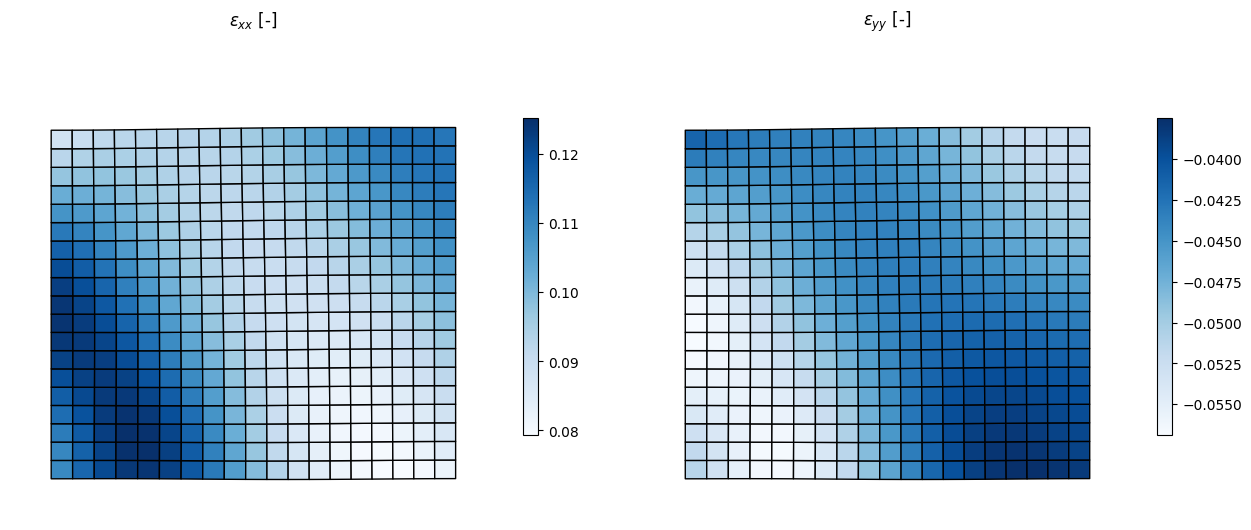

In [11]:
fig, axes = plt.subplots(1,2,figsize=(15,7))
plotmesh(elements, node_x2, F[:,0,0]-1.0, title='$\epsilon_{xx}$ [-]', ax=axes[0]); 
plotmesh(elements, node_x2, F[:,1,1]-1.0, title='$\epsilon_{yy}$ [-]', ax=axes[1]); 